# Assignment 2

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import abc
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(30)

## Task 1

**Description**
Apply the logistic regression method using the functions in the classwork notebook to predict biological response of a molecule. Data (bioresponse) from Kaggle

**Helper functions from classwork**

In [3]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

In [4]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.

    return w, b

**Forward and backward propagation**

In [5]:
def propagate(w, b, X, y):

    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    a = sigmoid(np.dot(w.T, X) + b)
    cost = -(1. / m) * np.sum(y * np.log(a) + (1 - y) * np.log(1 - a), axis = 1)
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1. / m) * np.dot(X, (a - y).T)
    db = (1. / m) * np.sum(a - y, axis = 1)

    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [6]:
w, b, X, y = np.array([[1.],[-1.]]), 4., np.array([[1.,5.,-1.],[10.,0.,-3.2]]), np.array([[0,1,1]])
grads, cost = propagate(w, b, X, y)
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost = " + str(cost))

dw = [[0.0027004 ]
 [0.02446984]]
db = [0.00151471]
cost = [0.00295537]


**Model optimization**

In [7]:
def optimize(w, b, X, y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -= learning_rate * dw
        b -= learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print (f"Cost after iteration {i}: {cost}")

    params = { "w": w, "b": b }
    grads = { "dw": dw, "db": db }
    
    return params, grads, costs

In [8]:
params, grads, costs = optimize(w, b, X, y, num_iterations= 1000, learning_rate = 0.005, print_cost = True)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 0: [0.00295537]
Cost after iteration 100: [0.00268273]
Cost after iteration 200: [0.00246141]
Cost after iteration 300: [0.00227804]
Cost after iteration 400: [0.00212352]
Cost after iteration 500: [0.00199147]
Cost after iteration 600: [0.00187724]
Cost after iteration 700: [0.00177742]
Cost after iteration 800: [0.00168939]
Cost after iteration 900: [0.00161115]
w = [[ 0.99092423]
 [-1.08149946]]
b = [3.99591156]
dw = [[0.00128065]
 [0.01144573]]
db = [0.00041775]


**Predictions**

In [9]:
def predict(w, b, X):
    m = X.shape[1]
    y_pred = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities
    a = sigmoid(np.dot(w.T, X) + b)

    for i in range(a.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if a[0,i] <= 0.5:
            y_pred[0][i] = 0
        else:
            y_pred[0][i] = 1

    return y_pred

In [10]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Wrap into model**

In [11]:
def model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    y_pred_test = predict(w, b, X_test)
    y_pred_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    d = {
        "costs": costs,
        "y_prediction_test": y_pred_test,
        "y_prediction_train" : y_pred_train,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations,
        "w" : w,
        "b" : b,
    }

    return d

**Load data**

In [12]:
df = pd.read_csv("../data/bioresponse.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y = df["Activity"]
X = df.drop(columns=["Activity"])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=30, test_size=0.25)

**Running the following (using unmodified code from class work yields shape incompatibility)**

In order to have this as part of part 1 of task 1 is it here, but to make notebook actually runnable I will comment it out

In [14]:
# model(
#     X_train, y_train.T,
#     X_test, y_test.T,
#     num_iterations = 2000,
#     learning_rate = 0.001,
#     print_cost = True
# )

## Use SGD and Adam for training

**Adam and SGD implementation**

In [15]:
class LearningRateScheduler(abc.ABC):
    @abc.abstractmethod
    def get(self, iteration: int = None, loss: int = None) -> float:
        pass

class ConstantLearningRate(LearningRateScheduler):
    def __init__(self, lr: float = 1e-7):
        self.lr = lr

    def get(self, iteration: int = None, loss: int = None) -> float:
        return self.lr

class Optimizer(abc.ABC):
    @abc.abstractmethod
    def step(self, parameters, gradient):
        pass

    @abc.abstractmethod
    def get_batch_size(self):
        pass

class SGD(Optimizer):

    def __init__(self,
                 batch_size: int = 16,
                 lr: LearningRateScheduler = ConstantLearningRate()):
        self.batch_size = batch_size
        self.lr = lr

    def step(self, parameters, gradient):
        delta = self.lr.get() * gradient
        return delta

    def get_batch_size(self) -> int:
        return self.batch_size

class Adam(Optimizer):

    def __init__(self,
                 batch_size: int = 16,
                 beta1: float = 0.9,
                 beta2: float = 0.999,
                 eps: float = 1e-7,
                 lr: LearningRateScheduler = ConstantLearningRate()):
        self.batch_size: int = batch_size
        self.beta1: float = beta1
        self.beta2: float = beta2
        self.eps: float = eps
        self.lr: LearningRateScheduler = lr
        self.cache: dict = {
            "t": -1,
            "mean": None,
            "var": None,
        }

    def get_batch_size(self) -> int:
        return self.batch_size

    def step(self, parameters, gradient):
        if self.cache["t"] == -1:
            self.cache = {
                "t": 0,
                "mean": np.zeros_like(parameters),
                "variance": np.zeros_like(parameters)
            }

        t = self.cache["t"] + 1
        mean = self.cache["mean"]
        variance = self.cache["variance"]

        self.cache["t"] = t
        self.cache["mean"] = self.beta1 * mean + (1 - self.beta1) * gradient
        self.cache["variance"] = self.beta2 * variance + (1 - self.beta2) * gradient ** 2

        v_hat = self.cache["variance"] / (1. - (self.beta2 ** t))
        m_hat = self.cache["mean"] / (1. - (self.beta1 ** t))

        update = self.lr.get(iteration=t) * m_hat / (np.sqrt(v_hat) + self.eps)
        return update

**Helpers to define the model**

In [16]:
def softmax(predictions):
    single = (predictions.ndim == 1)

    if single:
        predictions = predictions.reshape(1, predictions.shape[0])

    maximums = np.amax(predictions, axis=1).reshape(predictions.shape[0], 1)
    predictions_ts = predictions - maximums

    predictions_exp = np.exp(predictions_ts)
    sums = np.sum(predictions_exp, axis=1).reshape(predictions_exp.shape[0], 1)
    result = predictions_exp / sums

    if single:
        result = result.reshape(result.size)

    return result   # S

def cross_entropy_loss(probs, target_index):
    single = (probs.ndim == 1)

    if single:
        probs = probs.reshape(1, probs.shape[0])
        target_index = np.array([target_index])

    rows = np.arange(target_index.shape[0])
    cols = target_index

    return np.mean(-np.log(probs[rows, cols]))


def softmax_with_cross_entropy(predictions, target_index):
    single = (predictions.ndim == 1)

    if single:
        predictions = predictions.reshape(1, predictions.shape[0])
        target_index = np.array([target_index])

    probs = softmax(predictions)
    loss = cross_entropy_loss(probs, target_index)

    indicator = np.zeros(probs.shape)
    indicator[np.arange(probs.shape[0]), target_index] = 1
    dprediction = (probs - indicator) / predictions.shape[0]

    if single:
        dprediction = dprediction.reshape(dprediction.size)

    return loss, dprediction

def linear_softmax(X, W, target_index):
    predictions = np.dot(X, W)
    loss, dprediction = softmax_with_cross_entropy(predictions, target_index)

    dW = np.matmul(dprediction.T, X).T

    return loss, dW

In [17]:
class LinearSoftmaxClassifier:
    def __init__(self):
        self.W = None

    def fit(self, X, y, epochs=1, verbose=10, lr=0.001, X_eval: np.array = None, y_eval: np.array = None):
        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y) + 1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        loss_history = []
        for epoch in range(epochs):
            loss, dW = linear_softmax(X, self.W, y)
            self.W -= lr * dW

            if epoch % verbose  == 0:
                if X_eval is not None and y_eval is not None:
                    y_pred = self.predict(X_eval)
                    print(f"Epoch: \t{epoch},\t loss: {loss}, \t accuracy: {(y_pred == y_eval).mean()}")
                else:
                    print(f"Epoch: \t{epoch},\t loss: {loss}")

            loss_history.append(loss)

        return loss_history

    def predict(self, X):
        Z = np.dot(X, self.W)
        S = softmax(Z)

        return np.argmax(S, axis=1)
    

model = LinearSoftmaxClassifier()
history = model.fit(X_train.values, y_train.values, epochs=300, lr=0.1, X_eval=X_test, y_eval=y_test)

Epoch: 	0,	 loss: 0.6948792443487268, 	 accuracy: 0.5373134328358209
Epoch: 	10,	 loss: 0.848866370976625, 	 accuracy: 0.5373134328358209
Epoch: 	20,	 loss: 0.7615324057915739, 	 accuracy: 0.55863539445629
Epoch: 	30,	 loss: 0.687367727791638, 	 accuracy: 0.6066098081023454
Epoch: 	40,	 loss: 0.6242050102505279, 	 accuracy: 0.6588486140724946
Epoch: 	50,	 loss: 0.5748105131340145, 	 accuracy: 0.697228144989339
Epoch: 	60,	 loss: 0.5382617602479859, 	 accuracy: 0.7345415778251599
Epoch: 	70,	 loss: 0.5119311335523921, 	 accuracy: 0.7547974413646056
Epoch: 	80,	 loss: 0.4932707946112911, 	 accuracy: 0.755863539445629
Epoch: 	90,	 loss: 0.4803314684939719, 	 accuracy: 0.7569296375266524
Epoch: 	100,	 loss: 0.4715873096522851, 	 accuracy: 0.755863539445629
Epoch: 	110,	 loss: 0.4656683441292794, 	 accuracy: 0.7526652452025586
Epoch: 	120,	 loss: 0.4613774525553754, 	 accuracy: 0.7505330490405118
Epoch: 	130,	 loss: 0.4578957501894317, 	 accuracy: 0.7505330490405118
Epoch: 	140,	 loss: 0.45

So we got 0.76 accuracy, which is surprising considering how simple our model is

## Task 2

**Description**

Modify the code so that it works for SGD, (gradients are evaluated in batches)

In [18]:
class LinearSoftmaxClassifierBatched:
    def __init__(self):
        self.W = None

    def fit(self, X, y, epochs=1, verbose=10, optim = SGD(), X_eval: np.array = None, y_eval: np.array = None):
        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y) + 1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        loss_history = []
        for epoch in range(epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            batch_size = optim.get_batch_size()
            sections = np.arange(batch_size, num_train, batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            loss = np.nan
            for batch_indices in batches_indices:
                batch_X = X[batch_indices, :]
                batch_y = y[batch_indices]

                fn_loss, fn_dW = linear_softmax(batch_X, self.W, batch_y)

                loss = fn_loss
                dW = fn_dW

                self.W -= optim.step(self.W, dW)
            
            if epoch % verbose  == 0:
                if X_eval is not None and y_eval is not None:
                    y_pred = self.predict(X_eval)
                    print(f"Epoch: \t{epoch},\t loss: {loss}, \t accuracy: {(y_pred == y_eval).mean()}")
                else:
                    print(f"Epoch: \t{epoch},\t loss: {loss}")

            loss_history.append(loss)

        return loss_history

    def predict(self, X):
        Z = np.dot(X, self.W)
        S = softmax(Z)

        return np.argmax(S, axis=1)

## GD

In [19]:
def gd_training(lr):
    model = LinearSoftmaxClassifier()
    history = model.fit(X_train.values, y_train.values, epochs=200, lr=lr, X_eval=X_test, y_eval=y_test)
    plt.plot(history);

**lr = 0.0001**

Epoch: 	0,	 loss: 0.6922430390475499, 	 accuracy: 0.5575692963752665
Epoch: 	10,	 loss: 0.6917556264188549, 	 accuracy: 0.5490405117270789
Epoch: 	20,	 loss: 0.6912869406804631, 	 accuracy: 0.5469083155650319
Epoch: 	30,	 loss: 0.6908359595596347, 	 accuracy: 0.5405117270788913
Epoch: 	40,	 loss: 0.6904017169989232, 	 accuracy: 0.535181236673774
Epoch: 	50,	 loss: 0.6899833001239956, 	 accuracy: 0.5341151385927505
Epoch: 	60,	 loss: 0.6895798463657474, 	 accuracy: 0.535181236673774
Epoch: 	70,	 loss: 0.6891905407301094, 	 accuracy: 0.5362473347547975
Epoch: 	80,	 loss: 0.68881461320906, 	 accuracy: 0.5362473347547975
Epoch: 	90,	 loss: 0.6884513363264939, 	 accuracy: 0.5373134328358209
Epoch: 	100,	 loss: 0.6881000228127603, 	 accuracy: 0.5373134328358209
Epoch: 	110,	 loss: 0.6877600234018519, 	 accuracy: 0.5373134328358209
Epoch: 	120,	 loss: 0.6874307247454152, 	 accuracy: 0.5373134328358209
Epoch: 	130,	 loss: 0.6871115474379403, 	 accuracy: 0.5373134328358209
Epoch: 	140,	 loss: 0

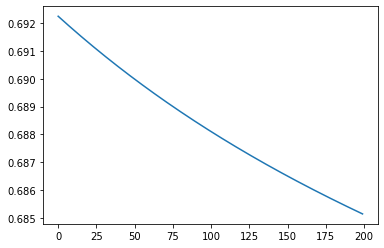

In [20]:
gd_training(lr=0.0001)

The curve is smooth (not surprising), both loss and accuracy are not that good so far

**lr = 0.001**

Epoch: 	0,	 loss: 0.6921311087904427, 	 accuracy: 0.5373134328358209
Epoch: 	10,	 loss: 0.6881174872337925, 	 accuracy: 0.5373134328358209
Epoch: 	20,	 loss: 0.6852182818132748, 	 accuracy: 0.5373134328358209
Epoch: 	30,	 loss: 0.6829553624741296, 	 accuracy: 0.5373134328358209
Epoch: 	40,	 loss: 0.6810601633477786, 	 accuracy: 0.5373134328358209
Epoch: 	50,	 loss: 0.6793816187548996, 	 accuracy: 0.5373134328358209
Epoch: 	60,	 loss: 0.6778345162524423, 	 accuracy: 0.5373134328358209
Epoch: 	70,	 loss: 0.6763706023967395, 	 accuracy: 0.5373134328358209
Epoch: 	80,	 loss: 0.6749624097603837, 	 accuracy: 0.5383795309168443
Epoch: 	90,	 loss: 0.6735941879822906, 	 accuracy: 0.5447761194029851
Epoch: 	100,	 loss: 0.6722568071374674, 	 accuracy: 0.5522388059701493
Epoch: 	110,	 loss: 0.6709448872544738, 	 accuracy: 0.5533049040511727
Epoch: 	120,	 loss: 0.6696551784138264, 	 accuracy: 0.5607675906183369
Epoch: 	130,	 loss: 0.6683856449679315, 	 accuracy: 0.5692963752665245
Epoch: 	140,	 los

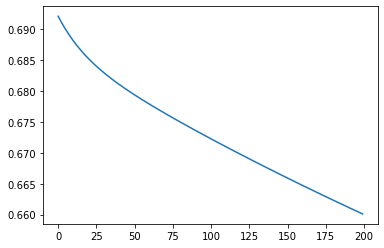

In [21]:
gd_training(lr=0.001)

Getting better

**lr = 0.01**

Epoch: 	0,	 loss: 0.6947398248200217, 	 accuracy: 0.5437100213219617
Epoch: 	10,	 loss: 0.6727045419088372, 	 accuracy: 0.5597014925373134
Epoch: 	20,	 loss: 0.6603462119473913, 	 accuracy: 0.6183368869936035
Epoch: 	30,	 loss: 0.6495177165454615, 	 accuracy: 0.6556503198294243
Epoch: 	40,	 loss: 0.6399146896621065, 	 accuracy: 0.6812366737739872
Epoch: 	50,	 loss: 0.6313199741214717, 	 accuracy: 0.685501066098081
Epoch: 	60,	 loss: 0.6235669794858562, 	 accuracy: 0.6929637526652452
Epoch: 	70,	 loss: 0.6165246889728516, 	 accuracy: 0.7057569296375267
Epoch: 	80,	 loss: 0.6100882853536244, 	 accuracy: 0.7110874200426439
Epoch: 	90,	 loss: 0.6041728482565882, 	 accuracy: 0.7196162046908315
Epoch: 	100,	 loss: 0.5987088817456122, 	 accuracy: 0.7228144989339019
Epoch: 	110,	 loss: 0.5936390201360728, 	 accuracy: 0.7270788912579957
Epoch: 	120,	 loss: 0.5889155402493262, 	 accuracy: 0.7238805970149254
Epoch: 	130,	 loss: 0.5844984504908304, 	 accuracy: 0.7292110874200426
Epoch: 	140,	 loss

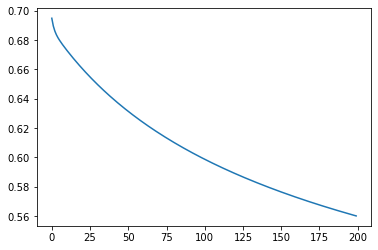

In [22]:
gd_training(lr=0.01)

Keeps getting better

**lr = 0.01**

Epoch: 	0,	 loss: 0.6934611252029299, 	 accuracy: 0.5373134328358209
Epoch: 	10,	 loss: 0.6253571923907855, 	 accuracy: 0.6343283582089553
Epoch: 	20,	 loss: 0.5802633222672139, 	 accuracy: 0.7100213219616205
Epoch: 	30,	 loss: 0.5527140618887179, 	 accuracy: 0.7388059701492538
Epoch: 	40,	 loss: 0.5357043717615895, 	 accuracy: 0.7345415778251599
Epoch: 	50,	 loss: 0.5229300086074349, 	 accuracy: 0.7452025586353944
Epoch: 	60,	 loss: 0.5127145355719926, 	 accuracy: 0.7505330490405118
Epoch: 	70,	 loss: 0.5042898401177828, 	 accuracy: 0.753731343283582
Epoch: 	80,	 loss: 0.4971773644699881, 	 accuracy: 0.7569296375266524
Epoch: 	90,	 loss: 0.4910590338288148, 	 accuracy: 0.7547974413646056
Epoch: 	100,	 loss: 0.48571429990981174, 	 accuracy: 0.7515991471215352
Epoch: 	110,	 loss: 0.48098499916957915, 	 accuracy: 0.7505330490405118
Epoch: 	120,	 loss: 0.4767545179036204, 	 accuracy: 0.7494669509594882
Epoch: 	130,	 loss: 0.4729348486759108, 	 accuracy: 0.7505330490405118
Epoch: 	140,	 lo

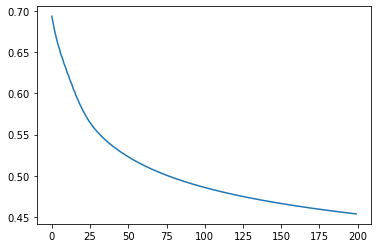

In [23]:
gd_training(lr=0.075)

This is as good as it gets here for GD, the other ones are not better

**lr = 0.5**

Epoch: 	0,	 loss: 0.6921110548754456, 	 accuracy: 0.5373134328358209
Epoch: 	10,	 loss: 7.9868438224843565, 	 accuracy: 0.5373134328358209
Epoch: 	20,	 loss: 4.202743570939252, 	 accuracy: 0.5373134328358209
Epoch: 	30,	 loss: 2.300122925042036, 	 accuracy: 0.5970149253731343
Epoch: 	40,	 loss: 2.989762996452664, 	 accuracy: 0.579957356076759
Epoch: 	50,	 loss: 2.7137060470112813, 	 accuracy: 0.6044776119402985
Epoch: 	60,	 loss: 2.4866723560968222, 	 accuracy: 0.6343283582089553
Epoch: 	70,	 loss: 2.269284878563079, 	 accuracy: 0.650319829424307
Epoch: 	80,	 loss: 2.1168353740524872, 	 accuracy: 0.6609808102345416
Epoch: 	90,	 loss: 2.009572245382119, 	 accuracy: 0.6684434968017058
Epoch: 	100,	 loss: 1.931315086471656, 	 accuracy: 0.6695095948827292
Epoch: 	110,	 loss: 1.8786244127210592, 	 accuracy: 0.6727078891257996
Epoch: 	120,	 loss: 1.7932386247932832, 	 accuracy: 0.6833688699360341
Epoch: 	130,	 loss: 1.8268802176877705, 	 accuracy: 0.6705756929637526
Epoch: 	140,	 loss: 1.697

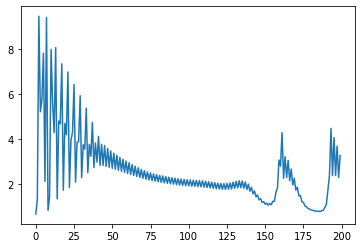

In [24]:
gd_training(lr=0.5)

That's a fun shape, seems like we are oscillating around the local minima, but the lr scheduler is constant, so we are kinda stuck

## SGD

In [25]:
def sgd_training(lr):
    model = LinearSoftmaxClassifierBatched()
    sgd = SGD(lr=ConstantLearningRate(lr), batch_size=64)
    history = model.fit(X_train.values, y_train.values, epochs=150, optim=sgd, X_eval=X_test, y_eval=y_test)
    plt.plot(history);

**lr = 0.0001**

Epoch: 	0,	 loss: 0.6937319747191704, 	 accuracy: 0.5405117270788913
Epoch: 	10,	 loss: 0.6964867134230518, 	 accuracy: 0.5373134328358209
Epoch: 	20,	 loss: 0.6711873520715763, 	 accuracy: 0.5447761194029851
Epoch: 	30,	 loss: 0.6766283774908084, 	 accuracy: 0.5714285714285714
Epoch: 	40,	 loss: 0.6541896322184934, 	 accuracy: 0.5991471215351812
Epoch: 	50,	 loss: 0.6832667791173274, 	 accuracy: 0.6140724946695096
Epoch: 	60,	 loss: 0.6505381681792463, 	 accuracy: 0.6364605543710021
Epoch: 	70,	 loss: 0.6601761857180516, 	 accuracy: 0.652452025586354
Epoch: 	80,	 loss: 0.6278768946480476, 	 accuracy: 0.6673773987206824
Epoch: 	90,	 loss: 0.6262665729984973, 	 accuracy: 0.6748400852878464
Epoch: 	100,	 loss: 0.6783177862317097, 	 accuracy: 0.6823027718550106
Epoch: 	110,	 loss: 0.6393664983130156, 	 accuracy: 0.6876332622601279
Epoch: 	120,	 loss: 0.6087952786374322, 	 accuracy: 0.6961620469083155
Epoch: 	130,	 loss: 0.6083203835253936, 	 accuracy: 0.6918976545842217
Epoch: 	140,	 loss

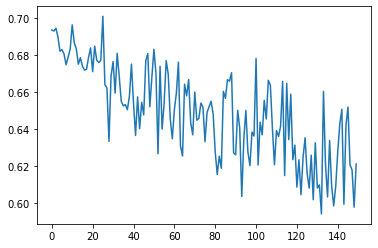

In [26]:
sgd_training(lr=0.0001)

Seems like this lr is too small, or we need to train more epochs

**lr = 0.0005**

Epoch: 	0,	 loss: 0.6941203138367339, 	 accuracy: 0.5373134328358209
Epoch: 	10,	 loss: 0.6560246114134918, 	 accuracy: 0.6332622601279317
Epoch: 	20,	 loss: 0.7000927314133386, 	 accuracy: 0.6833688699360341
Epoch: 	30,	 loss: 0.5956872819405652, 	 accuracy: 0.7014925373134329
Epoch: 	40,	 loss: 0.5729986848455636, 	 accuracy: 0.7217484008528785
Epoch: 	50,	 loss: 0.5930758876851498, 	 accuracy: 0.7249466950959488
Epoch: 	60,	 loss: 0.550593914893701, 	 accuracy: 0.7281449893390192
Epoch: 	70,	 loss: 0.558664939455632, 	 accuracy: 0.7313432835820896
Epoch: 	80,	 loss: 0.5559327384223897, 	 accuracy: 0.7345415778251599
Epoch: 	90,	 loss: 0.607932528253553, 	 accuracy: 0.732409381663113
Epoch: 	100,	 loss: 0.5664364651953278, 	 accuracy: 0.7345415778251599
Epoch: 	110,	 loss: 0.5552740242992176, 	 accuracy: 0.7345415778251599
Epoch: 	120,	 loss: 0.5057264078234044, 	 accuracy: 0.7334754797441365
Epoch: 	130,	 loss: 0.5315097194692681, 	 accuracy: 0.7345415778251599
Epoch: 	140,	 loss: 0

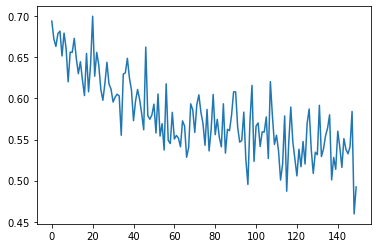

In [27]:
sgd_training(lr=0.0005)

Getting better for the loss, but accuracy doesn't go up, perhaps now the model tunes predictions to be closer to extremes (0 or 1), which doesn't affect accuracy metric but is important for the loss

**lr = 0.001**

Epoch: 	0,	 loss: 0.6867254455369749, 	 accuracy: 0.5373134328358209
Epoch: 	10,	 loss: 0.6603499168136642, 	 accuracy: 0.6940298507462687
Epoch: 	20,	 loss: 0.5963943749240608, 	 accuracy: 0.7228144989339019
Epoch: 	30,	 loss: 0.5889219634538789, 	 accuracy: 0.732409381663113
Epoch: 	40,	 loss: 0.5180393685104786, 	 accuracy: 0.7377398720682303
Epoch: 	50,	 loss: 0.5194161017850264, 	 accuracy: 0.7334754797441365
Epoch: 	60,	 loss: 0.5616290091565331, 	 accuracy: 0.7377398720682303
Epoch: 	70,	 loss: 0.5522307115029814, 	 accuracy: 0.7334754797441365
Epoch: 	80,	 loss: 0.5300182630684828, 	 accuracy: 0.7388059701492538
Epoch: 	90,	 loss: 0.5746657156747128, 	 accuracy: 0.7473347547974414
Epoch: 	100,	 loss: 0.45848466698723345, 	 accuracy: 0.7484008528784648
Epoch: 	110,	 loss: 0.537916430459968, 	 accuracy: 0.7505330490405118
Epoch: 	120,	 loss: 0.5877145351776558, 	 accuracy: 0.753731343283582
Epoch: 	130,	 loss: 0.5396891955687768, 	 accuracy: 0.7569296375266524
Epoch: 	140,	 loss:

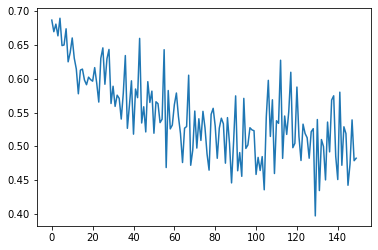

In [28]:
sgd_training(lr=0.001)

Less stable than the previous one, it gets to lower loss, but with higher variance for the loss. However, accuracy is the best we got so far

**lr = 0.005**

Epoch: 	0,	 loss: 0.6690445919945956, 	 accuracy: 0.6108742004264393
Epoch: 	10,	 loss: 0.5395434573177053, 	 accuracy: 0.7292110874200426
Epoch: 	20,	 loss: 0.4817589156811812, 	 accuracy: 0.7494669509594882
Epoch: 	30,	 loss: 0.5134985123312749, 	 accuracy: 0.7494669509594882
Epoch: 	40,	 loss: 0.43703074770000205, 	 accuracy: 0.7547974413646056
Epoch: 	50,	 loss: 0.524057576762793, 	 accuracy: 0.7526652452025586
Epoch: 	60,	 loss: 0.46758772251609193, 	 accuracy: 0.7494669509594882
Epoch: 	70,	 loss: 0.5264761954153712, 	 accuracy: 0.753731343283582
Epoch: 	80,	 loss: 0.4688044556741524, 	 accuracy: 0.753731343283582
Epoch: 	90,	 loss: 0.4757151573014777, 	 accuracy: 0.7579957356076759
Epoch: 	100,	 loss: 0.40517376407395467, 	 accuracy: 0.7611940298507462
Epoch: 	110,	 loss: 0.3973386813231114, 	 accuracy: 0.7601279317697228
Epoch: 	120,	 loss: 0.5062794743638606, 	 accuracy: 0.7643923240938166
Epoch: 	130,	 loss: 0.45767800054243707, 	 accuracy: 0.7622601279317697
Epoch: 	140,	 lo

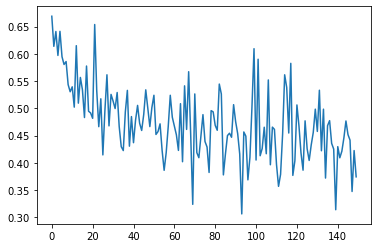

In [29]:
sgd_training(lr=0.005)

**lr = 0.1**

Epoch: 	0,	 loss: 0.7053237847665967, 	 accuracy: 0.6108742004264393
Epoch: 	10,	 loss: 0.47632313611935573, 	 accuracy: 0.7377398720682303
Epoch: 	20,	 loss: 0.3951184178096055, 	 accuracy: 0.7750533049040512
Epoch: 	30,	 loss: 0.3604862861986788, 	 accuracy: 0.767590618336887
Epoch: 	40,	 loss: 0.3559833671027548, 	 accuracy: 0.7718550106609808
Epoch: 	50,	 loss: 0.3028466335729931, 	 accuracy: 0.7633262260127932
Epoch: 	60,	 loss: 0.28116223374938837, 	 accuracy: 0.7579957356076759
Epoch: 	70,	 loss: 0.49492134255985726, 	 accuracy: 0.7697228144989339
Epoch: 	80,	 loss: 0.265403744239305, 	 accuracy: 0.7334754797441365
Epoch: 	90,	 loss: 0.30232204514853983, 	 accuracy: 0.7697228144989339
Epoch: 	100,	 loss: 0.43055545380859317, 	 accuracy: 0.755863539445629
Epoch: 	110,	 loss: 0.3806862562600888, 	 accuracy: 0.7611940298507462
Epoch: 	120,	 loss: 0.281947094253709, 	 accuracy: 0.755863539445629
Epoch: 	130,	 loss: 0.37287616331408824, 	 accuracy: 0.7494669509594882
Epoch: 	140,	 lo

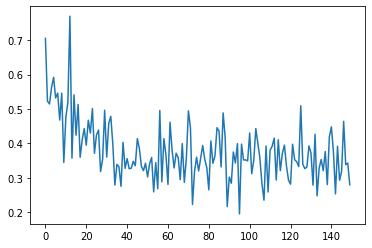

In [30]:
sgd_training(lr=0.1)

Actually it turns out that this lr works better then we previously picked as the best one, what happens if we increase it even more?

**lr = 0.6**

Epoch: 	0,	 loss: 4.587074421386854, 	 accuracy: 0.6044776119402985
Epoch: 	10,	 loss: 4.097296143983316, 	 accuracy: 0.535181236673774
Epoch: 	20,	 loss: 5.644577074198203, 	 accuracy: 0.5533049040511727
Epoch: 	30,	 loss: 5.662066329975324, 	 accuracy: 0.664179104477612
Epoch: 	40,	 loss: 1.4311526765635476, 	 accuracy: 0.6876332622601279
Epoch: 	50,	 loss: 1.7081633644159901, 	 accuracy: 0.6684434968017058
Epoch: 	60,	 loss: 0.8660307909885777, 	 accuracy: 0.7398720682302772
Epoch: 	70,	 loss: 1.3317176170930474, 	 accuracy: 0.7153518123667377
Epoch: 	80,	 loss: 3.718304985368468, 	 accuracy: 0.7228144989339019
Epoch: 	90,	 loss: 0.7531881032866617, 	 accuracy: 0.755863539445629
Epoch: 	100,	 loss: 0.8961492960374233, 	 accuracy: 0.7473347547974414
Epoch: 	110,	 loss: 0.6946635022660645, 	 accuracy: 0.697228144989339
Epoch: 	120,	 loss: 1.2621075182727486, 	 accuracy: 0.6801705756929638
Epoch: 	130,	 loss: 0.46035863407870675, 	 accuracy: 0.7569296375266524
Epoch: 	140,	 loss: 0.630

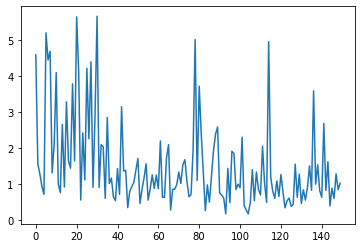

In [31]:
sgd_training(lr=0.6)

This is for sure too high

## Adam

In [32]:
def adam_training(lr):
    model = LinearSoftmaxClassifierBatched()
    adam = Adam(lr=ConstantLearningRate(lr), batch_size=64)
    history = model.fit(X_train.values, y_train.values, epochs=200, optim=adam, X_eval=X_test, y_eval=y_test)
    plt.plot(history);

**lr = 0.0001**

Epoch: 	0,	 loss: 0.6526986011553346, 	 accuracy: 0.5415778251599147
Epoch: 	10,	 loss: 0.5831274526997198, 	 accuracy: 0.7334754797441365
Epoch: 	20,	 loss: 0.5501741541823235, 	 accuracy: 0.7356076759061834
Epoch: 	30,	 loss: 0.5309394402521799, 	 accuracy: 0.746268656716418
Epoch: 	40,	 loss: 0.47405719921211575, 	 accuracy: 0.753731343283582
Epoch: 	50,	 loss: 0.4344270225977249, 	 accuracy: 0.7526652452025586
Epoch: 	60,	 loss: 0.4851094834275125, 	 accuracy: 0.7611940298507462
Epoch: 	70,	 loss: 0.4291258012792017, 	 accuracy: 0.753731343283582
Epoch: 	80,	 loss: 0.4855639919075759, 	 accuracy: 0.7590618336886994
Epoch: 	90,	 loss: 0.39671619769043276, 	 accuracy: 0.7633262260127932
Epoch: 	100,	 loss: 0.36385306948438695, 	 accuracy: 0.7697228144989339
Epoch: 	110,	 loss: 0.42298900507922677, 	 accuracy: 0.7729211087420043
Epoch: 	120,	 loss: 0.44953009185092685, 	 accuracy: 0.7697228144989339
Epoch: 	130,	 loss: 0.3382811456717191, 	 accuracy: 0.7707889125799574
Epoch: 	140,	 l

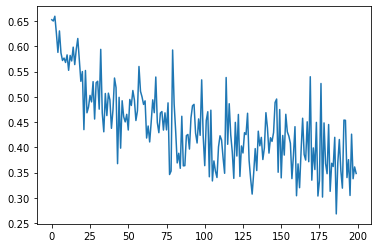

In [33]:
adam_training(lr=0.0001)

We are getting the results better than with GD and SDG, and the accuracy and loss seems to be more stable

**Bellow are some other lr with Adam**

In general it seems that (not very surprising) in most cases Adam is better than SGD both in stability and target metric

Epoch: 	0,	 loss: 0.5237151351954338, 	 accuracy: 0.7547974413646056
Epoch: 	10,	 loss: 0.4011874653233495, 	 accuracy: 0.7707889125799574
Epoch: 	20,	 loss: 0.312615565977311, 	 accuracy: 0.7601279317697228
Epoch: 	30,	 loss: 0.19732861581441746, 	 accuracy: 0.7633262260127932
Epoch: 	40,	 loss: 0.21916182744465665, 	 accuracy: 0.7505330490405118
Epoch: 	50,	 loss: 0.18261699713462035, 	 accuracy: 0.7569296375266524
Epoch: 	60,	 loss: 0.18408867480219404, 	 accuracy: 0.7579957356076759
Epoch: 	70,	 loss: 0.30130794926074395, 	 accuracy: 0.7526652452025586
Epoch: 	80,	 loss: 0.1762629988488655, 	 accuracy: 0.7473347547974414
Epoch: 	90,	 loss: 0.2670651390153462, 	 accuracy: 0.7249466950959488
Epoch: 	100,	 loss: 0.40541575550378506, 	 accuracy: 0.744136460554371
Epoch: 	110,	 loss: 0.21224331089037482, 	 accuracy: 0.7473347547974414
Epoch: 	120,	 loss: 0.25121157937245586, 	 accuracy: 0.7366737739872068
Epoch: 	130,	 loss: 0.21220254670733865, 	 accuracy: 0.7452025586353944
Epoch: 	14

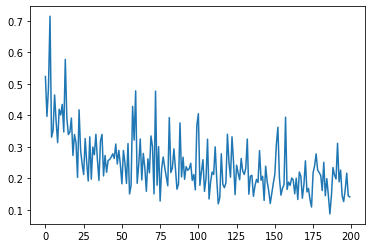

In [34]:
adam_training(lr=0.01)

Epoch: 	0,	 loss: 4.024522104925056, 	 accuracy: 0.697228144989339
Epoch: 	10,	 loss: 0.7819862888305981, 	 accuracy: 0.7238805970149254
Epoch: 	20,	 loss: 1.2259018985534085, 	 accuracy: 0.7046908315565032
Epoch: 	30,	 loss: 1.8625058245680717, 	 accuracy: 0.7228144989339019
Epoch: 	40,	 loss: 0.716420763676012, 	 accuracy: 0.7142857142857143
Epoch: 	50,	 loss: 0.3858919420576883, 	 accuracy: 0.7121535181236673
Epoch: 	60,	 loss: 0.4800483551150724, 	 accuracy: 0.7302771855010661
Epoch: 	70,	 loss: 1.2670598723559807, 	 accuracy: 0.7292110874200426
Epoch: 	80,	 loss: 0.47390197575118503, 	 accuracy: 0.7196162046908315
Epoch: 	90,	 loss: 1.9710214635458763, 	 accuracy: 0.7217484008528785
Epoch: 	100,	 loss: 1.3130927298436683, 	 accuracy: 0.7334754797441365
Epoch: 	110,	 loss: 1.0041024421679248, 	 accuracy: 0.6982942430703625
Epoch: 	120,	 loss: 0.6400349606865535, 	 accuracy: 0.7089552238805971
Epoch: 	130,	 loss: 0.418369291996974, 	 accuracy: 0.7281449893390192
Epoch: 	140,	 loss: 

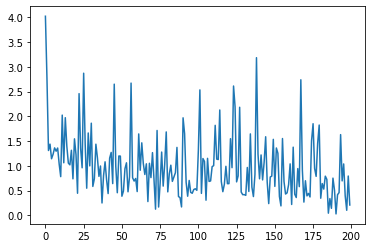

In [35]:
adam_training(lr=0.2)

Epoch: 	0,	 loss: 0.6700844595934227, 	 accuracy: 0.5607675906183369
Epoch: 	10,	 loss: 0.5904211701869587, 	 accuracy: 0.7270788912579957
Epoch: 	20,	 loss: 0.594235147025138, 	 accuracy: 0.7366737739872068
Epoch: 	30,	 loss: 0.4805008220472536, 	 accuracy: 0.746268656716418
Epoch: 	40,	 loss: 0.46168203089591137, 	 accuracy: 0.7505330490405118
Epoch: 	50,	 loss: 0.4904311393012501, 	 accuracy: 0.753731343283582
Epoch: 	60,	 loss: 0.44129183704216046, 	 accuracy: 0.7590618336886994
Epoch: 	70,	 loss: 0.4239484065356379, 	 accuracy: 0.7547974413646056
Epoch: 	80,	 loss: 0.4099454309325089, 	 accuracy: 0.7601279317697228
Epoch: 	90,	 loss: 0.36951175797046654, 	 accuracy: 0.7654584221748401
Epoch: 	100,	 loss: 0.3621307490641847, 	 accuracy: 0.7665245202558635
Epoch: 	110,	 loss: 0.456483650041712, 	 accuracy: 0.7718550106609808
Epoch: 	120,	 loss: 0.3951154120923091, 	 accuracy: 0.7707889125799574
Epoch: 	130,	 loss: 0.34504794827632146, 	 accuracy: 0.7729211087420043
Epoch: 	140,	 los

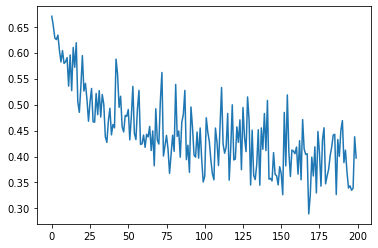

In [36]:
adam_training(lr=0.0001)

Epoch: 	0,	 loss: 0.5901063382271676, 	 accuracy: 0.6609808102345416
Epoch: 	10,	 loss: 0.5544321515966871, 	 accuracy: 0.7526652452025586
Epoch: 	20,	 loss: 0.5209658380461031, 	 accuracy: 0.7697228144989339
Epoch: 	30,	 loss: 0.3974367003600471, 	 accuracy: 0.7707889125799574
Epoch: 	40,	 loss: 0.4485279220153601, 	 accuracy: 0.7761194029850746
Epoch: 	50,	 loss: 0.3584699170350459, 	 accuracy: 0.7718550106609808
Epoch: 	60,	 loss: 0.3554419441905744, 	 accuracy: 0.7729211087420043
Epoch: 	70,	 loss: 0.44969220031685897, 	 accuracy: 0.7739872068230277
Epoch: 	80,	 loss: 0.44772977076687237, 	 accuracy: 0.7750533049040512
Epoch: 	90,	 loss: 0.3685001929902915, 	 accuracy: 0.7739872068230277
Epoch: 	100,	 loss: 0.3570497671846352, 	 accuracy: 0.767590618336887
Epoch: 	110,	 loss: 0.2720343331448648, 	 accuracy: 0.7846481876332623
Epoch: 	120,	 loss: 0.28924926331633205, 	 accuracy: 0.7729211087420043
Epoch: 	130,	 loss: 0.26656476177338106, 	 accuracy: 0.7739872068230277
Epoch: 	140,	 

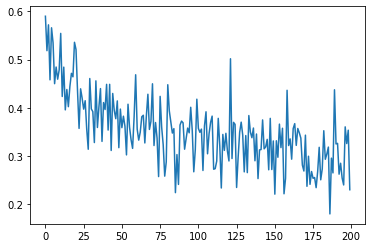

In [37]:
adam_training(lr=0.0005)